In [29]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split 
from sklearn.utils import class_weight

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3


import tensorflow_hub as hub

In [33]:
filelist  = []

for dirname, _, filenames in os.walk('photos/dog_breeds_data/images/Images'):
    for filename in filenames:
        filelist.append(os.path.join(dirname, filename))

In [34]:
len(filelist)

20580

In [35]:
Filepaths   = []
labels = []
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2].split('-')[1]

    Filepaths.append(image_file)
    labels.append(label)

In [36]:
len(Filepaths), len(labels)

(20580, 20580)

In [8]:
Filepaths[:5], labels[:5]

(['photos/dog_breeds_data/images/Images\\n02085620-Chihuahua\\n02085620_10074.jpg',
  'photos/dog_breeds_data/images/Images\\n02085620-Chihuahua\\n02085620_10131.jpg',
  'photos/dog_breeds_data/images/Images\\n02085620-Chihuahua\\n02085620_10621.jpg',
  'photos/dog_breeds_data/images/Images\\n02085620-Chihuahua\\n02085620_1073.jpg',
  'photos/dog_breeds_data/images/Images\\n02085620-Chihuahua\\n02085620_10976.jpg'],
 ['Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua', 'Chihuahua'])

In [9]:
len(set(labels))

120

In [10]:
df = pd.DataFrame(list(zip(Filepaths, labels)), columns = ['Filepath', 'Labels'] )
df = (df.sample(frac = 1, random_state=42).reset_index()).drop(columns = 'index')
df.head()

,Filepath,Labels
0,photos/dog_breeds_data/images/Images\n02109047...,Great_Dane
1,photos/dog_breeds_data/images/Images\n02090622...,borzoi
2,photos/dog_breeds_data/images/Images\n02113978...,Mexican_hairless
3,photos/dog_breeds_data/images/Images\n02087046...,toy_terrier
4,photos/dog_breeds_data/images/Images\n02113712...,miniature_poodle


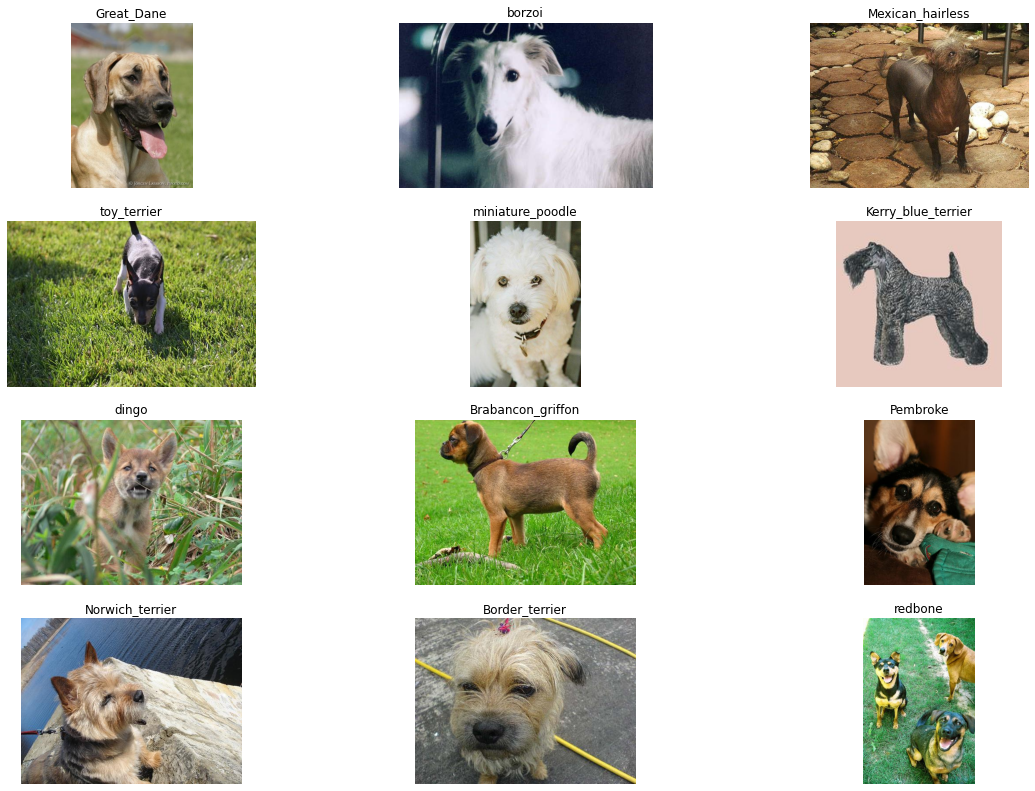

In [10]:
fig, axis = plt.subplots(4, 3,figsize=(20, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    ax.axis('off')
    
plt.show()

In [11]:
pd.value_counts(df['Labels'],ascending=False).head(10)

Maltese_dog             252
Afghan_hound            239
Scottish_deerhound      232
Pomeranian              219
Bernese_mountain_dog    218
Samoyed                 218
Irish_wolfhound         218
Shih                    214
Great_Pyrenees          213
Leonberg                210
Name: Labels, dtype: int64

In [12]:
pd.DataFrame(df['Labels'].unique()).to_csv("dog_breeds.csv", index=False, header=False)

In [13]:
val_ratio = test_ratio = 0.2

train, test = train_test_split(df, test_size=test_ratio, random_state=42)
val, test = train_test_split(test, test_size=val_ratio, random_state=42)
len(train), len(val), len(test)

(16464, 3292, 824)

In [14]:
img_datagen = ImageDataGenerator(rescale=1./255, 
                                 rotation_range=30, 
                                 width_shift_range=0.2,
                                 height_shift_range=0.2, 
                                 horizontal_flip = 'true')


In [15]:
train_generator=img_datagen.flow_from_dataframe(dataframe=train,
                                                x_col="Filepath",
                                                y_col="Labels",
                                                batch_size=32,
                                                seed=42,
                                                shuffle=True,
                                                target_size=(224, 224))

Found 16464 validated image filenames belonging to 120 classes.


In [16]:
val_generator=img_datagen.flow_from_dataframe(dataframe=val,
                                              x_col="Filepath",
                                              y_col="Labels",
                                              batch_size=32,
                                              seed=42,
                                              shuffle=True,
                                              target_size=(224, 224))

test_generator=img_datagen.flow_from_dataframe(dataframe=test,
                                               x_col="Filepath",
                                               y_col="Labels",
                                               batch_size=32,
                                               seed=42,
                                               shuffle=True,
                                               target_size=(224, 224))

Found 3292 validated image filenames belonging to 120 classes.
Found 824 validated image filenames belonging to 120 classes.


In [24]:
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

In [25]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 35, 35, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 35, 35, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 35, 35, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 35, 35, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 35, 35, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 35, 35, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 35, 35, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 17, 17, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 17, 17, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 17, 17, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 17, 17, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 17, 17, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 17, 17, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 17, 17, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 17, 17, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 17, 17, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 17, 17, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 17, 17, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 17, 17, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 17, 17, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 17, 17, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 17, 17, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 8, 8, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 8, 8, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 8, 8, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 8, 8, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [21]:
mod = hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/classification/5")

model = Sequential()
model.add(mod)

# model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(120, activation = 'softmax'))

model.build([None, 224, 224, 3])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1001)              5508713   
                                                                 
 dense_6 (Dense)             (None, 128)               128256    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 120)               15480     
                                                                 
Total params: 5,652,449
Trainable params: 143,736
Non-trainable params: 5,508,713
_________________________________________________________________


In [22]:
model.compile(optimizer = Adam(),
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [23]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [24]:
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
514/514 [==============================] - 587s 1s/step - loss: 1.6033 - accuracy: 0.5949 - val_loss: 1.0013 - val_accuracy: 0.7227
Epoch 2/10
514/514 [==============================] - 454s 884ms/step - loss: 0.9342 - accuracy: 0.7303 - val_loss: 0.9793 - val_accuracy: 0.7249
Epoch 3/10
514/514 [==============================] - 441s 858ms/step - loss: 0.7996 - accuracy: 0.7682 - val_loss: 0.9134 - val_accuracy: 0.7451
Epoch 4/10
514/514 [==============================] - 436s 847ms/step - loss: 0.7344 - accuracy: 0.7813 - val_loss: 0.9866 - val_accuracy: 0.7454
Epoch 5/10
514/514 [==============================] - 408s 794ms/step - loss: 0.6705 - accuracy: 0.7965 - val_loss: 0.9928 - val_accuracy: 0.7436
Epoch 6/10
514/514 [==============================] - 452s 880ms/step - loss: 0.6653 - accuracy: 0.8019 - val_loss: 0.9928 - val_accuracy: 0.7328
Epoch 7/10
514/514 [==============================] - 679s 1s/step - loss: 0.6323 - accuracy: 0.8064 - val_loss: 0.9964 - val_a

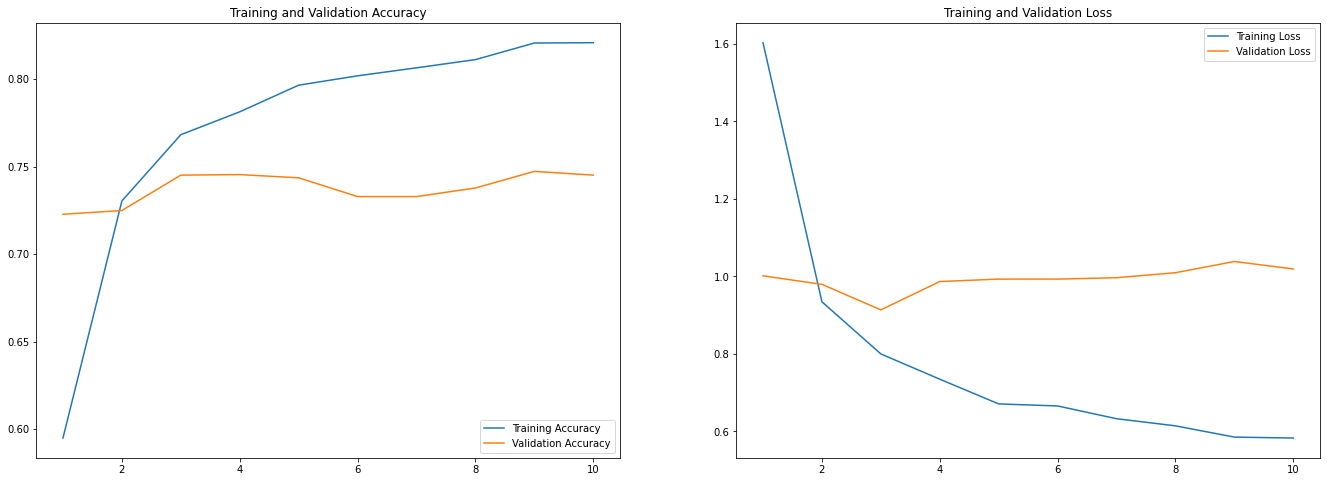

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
model.evaluate(test_generator,
               steps=STEP_SIZE_TEST)

25/25 [==============================] - 52s 2s/step - loss: 1.0111 - accuracy: 0.7350


[1.0111231803894043, 0.7350000143051147]

In [28]:
model_score = model.evaluate(test_generator, steps=STEP_SIZE_TEST)

print("Model Test Loss:",model_score[0])
print("Model Test Accuracy:",model_score[1])
    
model.save("model/dog_breeds_model2.h5")
print("Weights Saved")

25/25 [==============================] - 43s 2s/step - loss: 1.0286 - accuracy: 0.7287
Model Test Loss: 1.028632640838623
Model Test Accuracy: 0.7287499904632568
Weights Saved
